In [1]:
import numpy as np
from tensorflow.python.keras.models import Sequential
import keras
from keras import *
from keras.src.layers import Embedding, LSTM, Dense, Dropout, Input
from keras.src.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from keras import backend as K
import tensorflow as tf

In [2]:
df=pd.read_csv("../input.csv")

In [3]:
test_split = 117

In [4]:
test_split = 117
total_steps = len(df)
df_for_testing = df[-test_split:]
df_remaining = df[:total_steps - test_split]

In [5]:
validation_split = int(len(df_remaining) * 0.10)
df_for_validation = df_remaining[-validation_split:]
df_for_training = df_remaining[:-validation_split]

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_validation_scaled = scaler.transform(df_for_validation)
df_for_testing_scaled = scaler.transform(df_for_testing)

In [7]:
def createXY(dataset, sequence_length):
    X, y = [], []
    for i in range(len(dataset) - sequence_length):
        X.append(dataset[i:i + sequence_length])
        y.append(dataset[i + sequence_length])
    return np.array(X), np.array(y)

In [8]:
trainX,trainY=createXY(df_for_training_scaled,25)

In [9]:
validationX, validationY = createXY(df_for_validation_scaled, 25)

In [10]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [11]:
def theil_u_statistic(y_true, y_pred):
    # Ensure y_true and y_pred have compatible shapes
    actual = y_true[:, :-1]  # Current actual values
    actual_next = y_true[:, 1:]  # Next actual values
    predicted = y_pred[:, :-1]  # Predicted values corresponding to current actuals

    # Compute the numerator: sum of squared differences between actual and predicted
    numerator = K.sum(K.square(actual - predicted), axis=-1)

    # Compute the denominator: sum of squared differences between current actual and next actual
    denominator = K.sum(K.square(actual - actual_next), axis=-1)

    # Calculate Theil's U statistic
    theil_u = numerator / (denominator + K.epsilon())  # Add epsilon to avoid division by zero

    # Return the mean Theil's U statistic over the batch
    return K.mean(theil_u)

In [12]:
def build_model(optimizer='adam'):
    model = Sequential()

    model.add(Input(shape=(25, 3)))
    model.add(Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.2)))
    model.add(Dropout(0.2))

    model.add(LayerNormalization())
    model.add(Bidirectional(LSTM(200, return_sequences=True, recurrent_dropout=0.2)))
    model.add(Dropout(0.2))

    model.add(LayerNormalization())
    model.add(Bidirectional(LSTM(100, recurrent_dropout=0.2)))
    model.add(Dropout(0.2))
    model.add(LayerNormalization())
    
    model.add(Dense(3))
    model.compile(loss='mse', optimizer=optimizer)
    return model

grid_model = KerasRegressor(model=build_model,verbose=1, validation_split=0.10)
parameters = {'batch_size' : [4,16,20,32],
              'epochs' : [4,8,10,20],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

In [13]:
grid_search = grid_search.fit(trainX,trainY, validation_data=(validationX, validationY))

Epoch 1/4
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 1.6738 - val_loss: 0.0403
Epoch 2/4
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.3100 - val_loss: 0.0514
Epoch 3/4
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2592 - val_loss: 0.0641
Epoch 4/4
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1966 - val_loss: 0.0747
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/4
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.2632 - val_loss: 0.1116
Epoch 2/4
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3348 - val_loss: 0.1714
Epoch 3/4
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2336 - val_loss: 0.0964
Epoch 4/4
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1980 - val_loss: 0.0793
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Epoch 1/4
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 1.3685 - val_loss: 0.1566
Epoch 2/4
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2990 - val_loss: 0.1457
Epoch 3/4
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - los

In [27]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 20, 'optimizer': 'Adadelta'}

In [28]:
grid_search

GridSearchCV(cv=2,
             estimator=KerasRegressor(model=<function build_model at 0x000002B5AAA90400>, validation_split=0.1),
             param_grid={'batch_size': [4, 16, 20, 32],
                         'epochs': [4, 8, 10, 20],
                         'optimizer': ['adam', 'Adadelta']})

In [29]:
my_model=grid_search.best_estimator_

In [30]:
my_model.model

<function __main__.build_model(optimizer='adam')>

In [31]:
test_predictions = []
input_seq = np.concatenate((df_for_training_scaled[-24:], df_for_testing_scaled[:1]), axis=0)


In [32]:
for i in range(len(df_for_testing_scaled) - 1):
    input_seq_reshaped = input_seq.reshape((1, 25, 3))
    predicted_value = my_model.predict(input_seq_reshaped, verbose=0)
    test_predictions.append(predicted_value[0])
    input_seq = np.append(input_seq[1:], predicted_value, axis=0)

In [33]:
test_predictions = np.array(test_predictions)
pred = scaler.inverse_transform(test_predictions)
original = scaler.inverse_transform(df_for_testing_scaled[1:])

In [34]:
import matplotlib.pyplot as plt

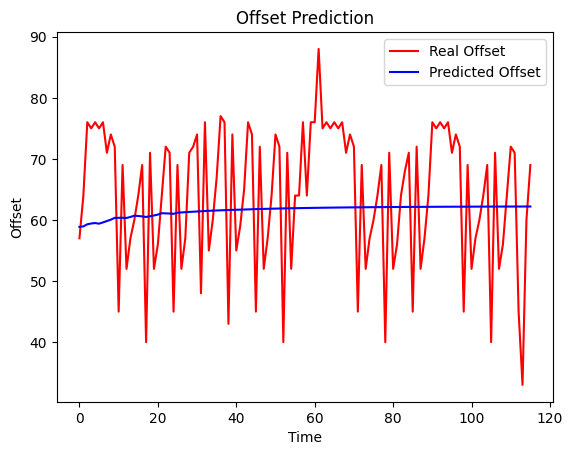

In [35]:
# Plot the results
pred_offsets = pred[:, 2]
original_offsets = original[:, 2]
plt.plot(original_offsets, color='red', label='Real Offset')
plt.plot(pred_offsets, color='blue', label='Predicted Offset')
plt.title('Offset Prediction')
plt.xlabel('Time')
plt.ylabel('Offset')
plt.legend()
plt.show()

In [36]:
my_model.model_.summary()

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_192               │ (None, 25, 200)        │        83,200 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_192 (Dropout)           │ (None, 25, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_192         │ (None, 25, 200)        │           400 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_193               │ (None, 25, 400)        │       641,600 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_193 (Dropout)           │ (None, 25, 400)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_193         │ (None, 25, 400)        │           800 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_194               │ (None, 200)            │       400,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_194 (Dropout)           │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_194         │ (None, 200)            │           400 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 3)              │           603 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,383,411 (12.91 MB)

 Trainable params: 1,127,803 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,255,608 (8.60 MB)

"In general, the complexity of a neural network structure is measured by the number of free parameters in the network; that is, the number of neurons and the number and strength of connections between neurons." - https://books.google.ca/books?id=uyhqCQAAQBAJ&pg=PA40&lpg=PA40&dq=%22In+general,+the+complexity+of+a+neural+network+structure+is+measured+by+the+number+of+free+parameters+in+the+network;+that+is,+the+number+of+neurons+and+the+number+and+strength+of+connections+between+neurons.%22&source=bl&ots=_pXj5d9-jl&sig=ACfU3U0brK9RIChTFaLqvO4uclk2jz3Rzg&hl=en&sa=X&ved=2ahUKEwiGxouP-uiGAxV74MkDHezoBIEQ6AF6BAgFEAM#v=onepage&q=%22In%20general%2C%20the%20complexity%20of%20a%20neural%20network%20structure%20is%20measured%20by%20the%20number%20of%20free%20parameters%20in%20the%20network%3B%20that%20is%2C%20the%20number%20of%20neurons%20and%20the%20number%20and%20strength%20of%20connections%20between%20neurons.%22&f=false


"Specifically, deep learning assumes that the neural architecture is designed a priori, with the same architecture employed for each game title. Thus, deep learning always performs millions of calculations per decision. TPG, on the other hand, has the potential to tune policy complexity to each task environment, or game title, requiring only 
 calculations per decision in the most complex case, and 
 calculations in the simpler cases." - https://direct.mit.edu/evco/article/26/3/347/1067/Emergent-Solutions-to-High-Dimensional-Multitask